In [136]:
# Initialize Otter
import otter
grader = otter.Notebook("projA1.ipynb")

In [137]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data


The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is `Sale Price`, which you will predict with linear regression in the next part of this project. An explanation of each variable can be found in the included `codebook.txt` file (you can optionally open this by first clicking the `data` folder, then clicking `codebook.txt` file in the navigation pane). Some of the columns have been filtered out to ensure this assignment doesn't become overly long when dealing with data cleaning and formatting.

The data are split into training and test sets with 204,792 and 68,264 observations, respectively, but we will only be working on the training set for this part of the project.

In [138]:
with zipfile.ZipFile('data/cook_county_data.zip') as item:
    item.extractall()

In [139]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

In [140]:
# 204,792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

In [141]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: Exploratory Data Analysis

This dataset was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home. You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf). 

I performed EDA on the **training data**.

In [143]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

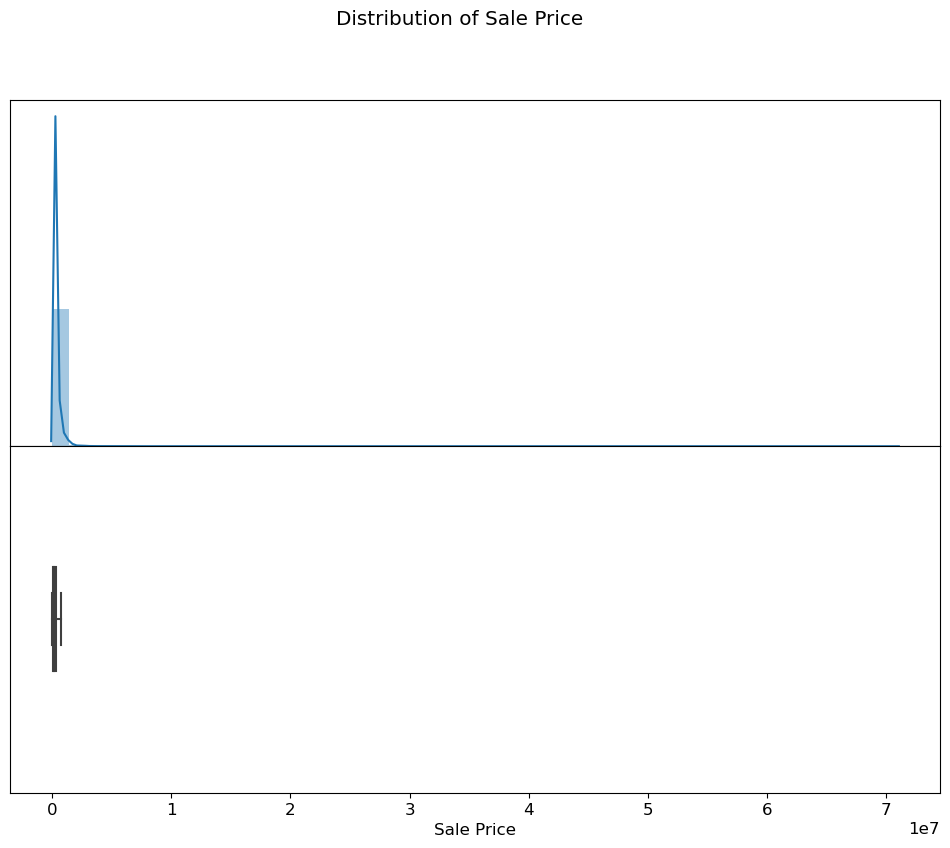

In [144]:
plot_distribution(training_data, label='Sale Price')

In [145]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

In [147]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])
training_data['Log Sale Price'].sum()

2055590.7351105125

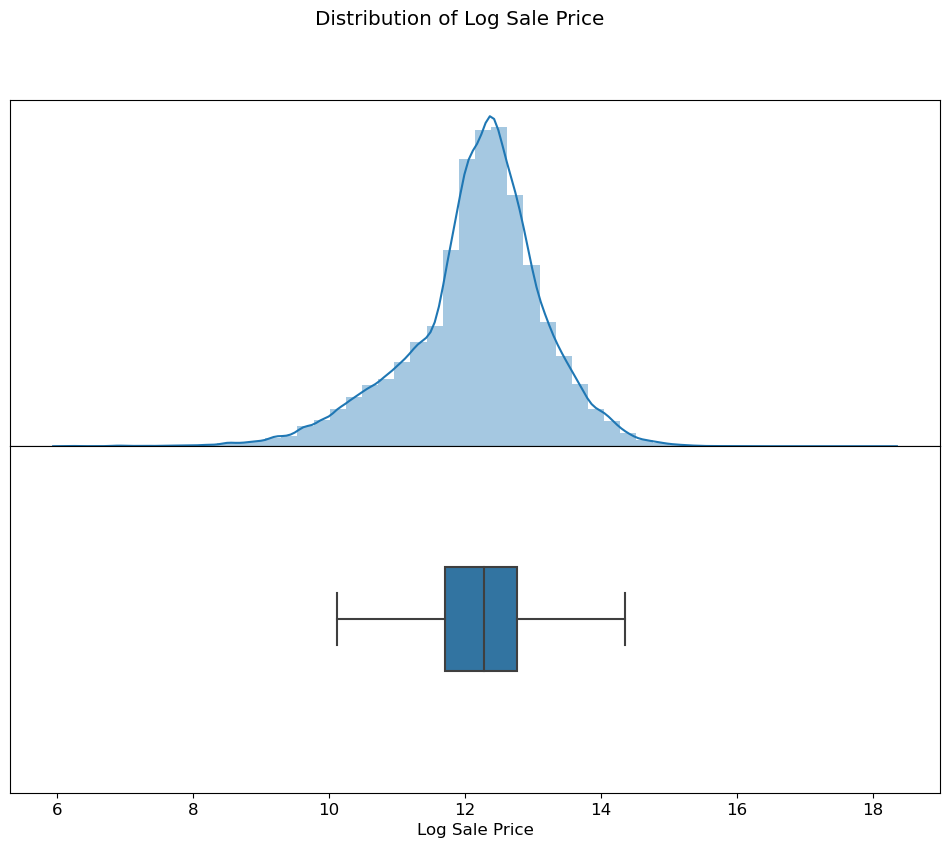

In [149]:
plot_distribution(training_data, label='Log Sale Price');

In [152]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

In [154]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data.loc[(data['Building Square Feet']<=upper) & (data['Building Square Feet']>lower)]
   

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Feature Engineering


<br><br>

In [159]:
training_data['Description'][1]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [160]:

def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bedrooms" containing ints.

    """
    with_rooms = data.copy()
    rooms_regex = r'(\d+) of which are bedrooms'
    rooms = with_rooms['Description'].str.extract(rooms_regex).astype(int)
    with_rooms['Bedrooms'] = rooms

    return with_rooms

training_data = add_total_bedrooms(training_data)




Text(0.5, 1.0, 'Log Scale Price Destribution Depending on the Number of Bathrooms')

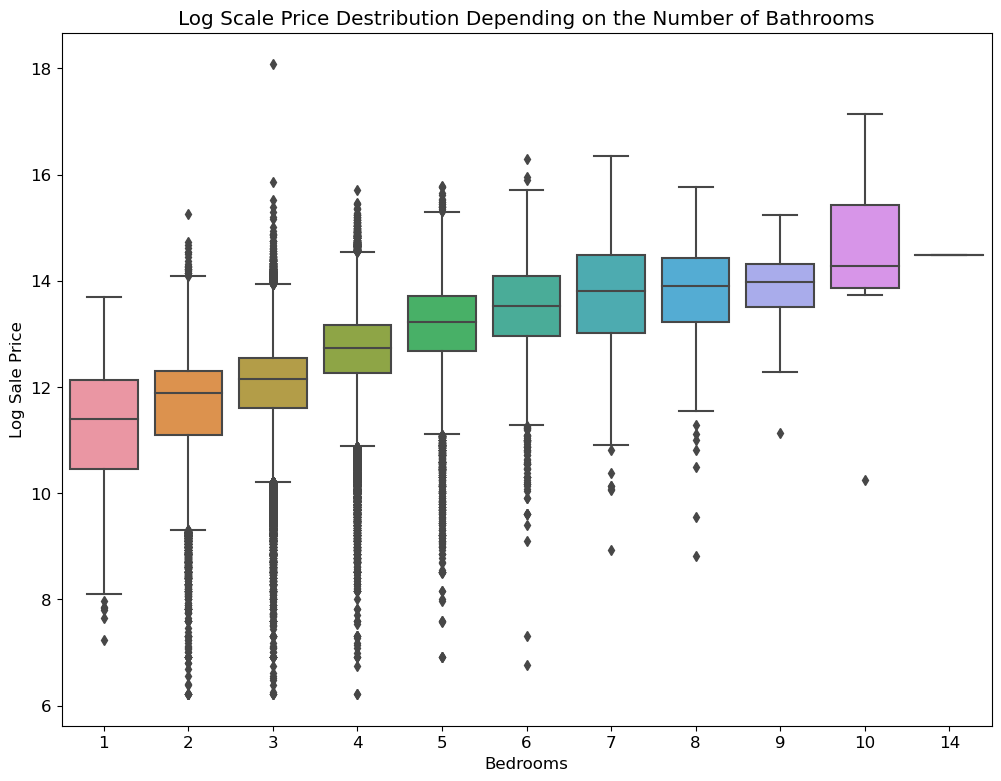

In [162]:
sns.boxplot(x = 'Bedrooms', y = 'Log Sale Price', data = training_data)
plt.title("Log Scale Price Destribution Depending on the Number of Bathrooms")

In [163]:
num_neighborhoods = training_data['Neighborhood Code'].nunique()
num_neighborhoods

193

In [165]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

In [166]:
top_20_neighborhood_codes = training_data['Neighborhood Code'].value_counts().head(20).index.tolist()

in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_20_neighborhood_codes)]

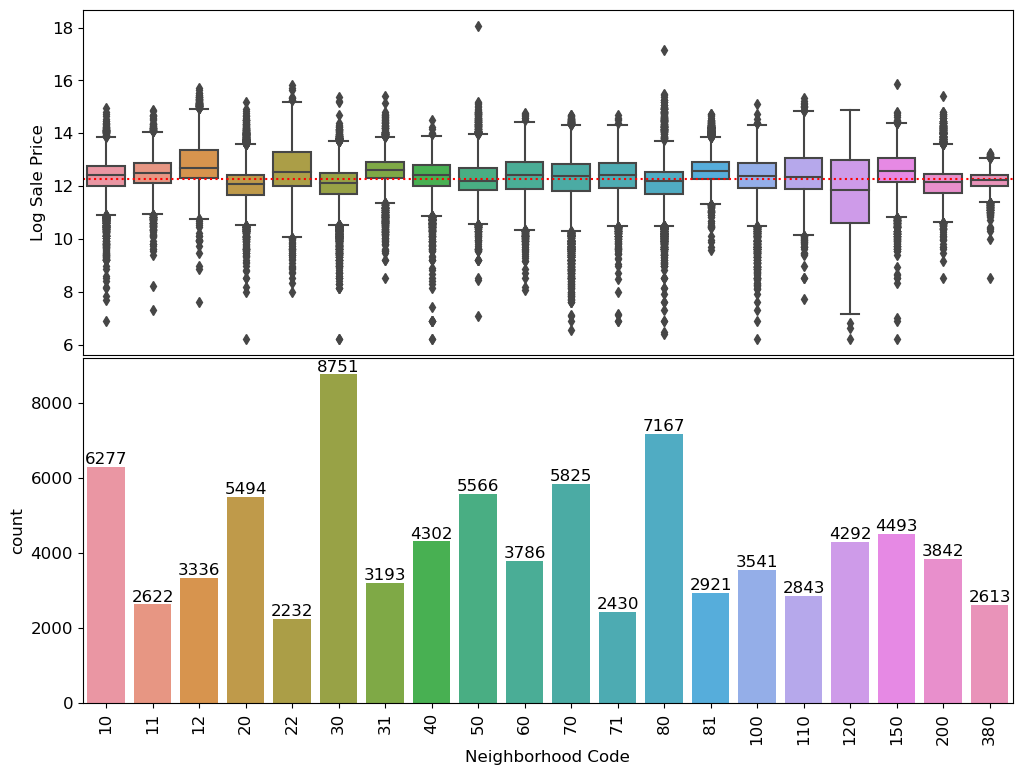

In [168]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

In [169]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least a int-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood Code')['Log Sale Price'].agg(metric).sort_values(ascending=False).head(n).index.values

    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

In [170]:
training_data[['Neighborhood Code','Log Sale Price']].sort_values(by=['Log Sale Price'])


,Neighborhood Code,Log Sale Price
145108,30,6.214608
54841,194,6.214608
120532,20,6.214608
44530,100,6.214608
19382,102,6.214608
...,...,...
19702,171,16.300417
929,171,16.321036
37835,171,16.357113
71953,80,17.147715


In [172]:
def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype('int32')
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In [174]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    replacements = {
        'Roof Material': {
            1: 'Shingle/Asphalt',
            2: 'Tar & Gravel',
            3: 'Slate',
            4: 'Shake',
            5: 'Tile',
            6: 'Other',
    }
    }
    data = data.replace(replacements)
    return data
    
training_data_mapped = substitute_roof_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0


In [176]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Roof Material']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Roof Material']]).todense(),columns=oh_enc.get_feature_names_out(),index=data.index)
    return data.join(dummies)
training_data_ohe = ohe_roof_material(training_data_mapped)
# This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar & Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0
